# Using Alpha Vantage API To See Market Trends

## Web scrapping

In [51]:
#Used for pulling the data
import urllib.request 
import json
#Used for formatting the data
import pandas as pd
#Used for data visualisation
import matplotlib.pyplot as plt
from matplotlib import style
#Webscrape wikipedia for lockdown start dates and end dates
from bs4 import BeautifulSoup

In [3]:
#URL for the wikipedia page
url = "https://en.wikipedia.org/wiki/COVID-19_pandemic_lockdowns"

#Open the webpage
page = urllib.request.urlopen(url)

#Read and extract the HTML from the page
soup = BeautifulSoup(page, "lxml")

#Find the correct table with all the details needed
right_table = soup.find("table", class_="wikitable sortable mw-collapsible")

In [7]:
#Go through the HTML to find the <tr> tags which contain the country name, start date and end date of lockdowns
countries = []
startDate=[]
endDate=[]

#Extract information required from the tags
for row in right_table.findAll('tr'):
    
    #Information stored in <td> tags
    #Find all <td> tags
    cells=row.findAll('td')
    
    #3 <td> tags per <tr> tag
    if len(cells)==3:
        getCountry = cells[0].findAll('a')
        countries.append(getCountry[0].contents[0])
        startDate.append(cells[1].find(text=True))        
        endDate.append(cells[2].find(text=True))

In [8]:
#Create dataframe with country name, start date, end date
df=pd.DataFrame(countries,columns=['Country & Areas'])
df['Start Date']=startDate
df['End Date']=endDate

#Display 30 rows only
pd.set_option('display.max_rows',50)

In [9]:
#Checking to see if there are any null values to clean
df.isnull().values.any()

False

In [10]:
#Replace the anomalous data which contains the strings "Area" and "City". This has only occurred in the Saudi Arabia data.
df.at[45, 'End Date'] = ""
df.at[46, 'End Date'] = ""
df

,Country & Areas,Start Date,End Date
0,Armenia,2020-03-24,2020-05-04
1,Australia,2020-03-23,
2,Austria,2020-03-16,2020-04-13
3,Azerbaijan,2020-03-31,2020-04-20
4,Bangladesh,2020-03-26,2020-05-16
5,Barbados,2020-03-28,2020-05-03
6,Belgium,2020-03-18,2020-05-04
7,Bermuda,2020-04-04,2020-05-02
8,Bolivia,2020-03-22,2020-07-31
9,Botswana,2020-04-02,2020-04-30


In [11]:
#Output the number of countries announcing lockdown in March
print("Number of countries/Area in lockdown beginning March: " + str(len(df.loc[df['Start Date'].str.contains('2020-03')])) + "/" + str(len(df['Start Date'])))

Number of countries/Area in lockdown beginning March: 57/63


In [12]:
#Output the number of countries announcing the easing of lockdown by June
easeApril = len(df.loc[df['End Date'].str.contains('2020-04')])
easeMay = len(df.loc[df['End Date'].str.contains('2020-05')])
easeJune = len(df.loc[df['End Date'].str.contains('2020-06')])
easeJuly = len(df.loc[df['End Date'].str.contains('2020-07')])
print("Number of countries/Area out of lockdown by April: " + str(easeApril) + "/" + str(len(df['End Date'])))
print("Number of countries/Area out of lockdown by May: " + str((easeApril+easeMay)) + "/" + str(len(df['End Date'])))
print("Number of countries/Area out of lockdown by June: " + str((easeApril+easeMay+easeJune)) + "/" + str(len(df['End Date'])))
print("Number of countries/Area out of lockdown by July: " + str((easeApril+easeMay+easeJune+easeJuly)) + "/" + str(len(df['End Date'])))

Number of countries/Area out of lockdown by April: 23/63
Number of countries/Area out of lockdown by May: 40/63
Number of countries/Area out of lockdown by June: 48/63
Number of countries/Area out of lockdown by July: 49/63


In [52]:
apikey = "Y11HUWNU7HM58RRL"

In [53]:
#Returns a pandaDF of the closing stock prices in the last x amount of days
def getPriceOfStock(companySymbol, numOfDays):
    
    #Obtaining the URL and making a request
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol="+companySymbol+"&outputsize=full&apikey="+apikey
    json_obj = urllib.request.urlopen(url)
    
    #Finds the data from the url
    data = json.load(json_obj)
    
    #Choosing the revelant key from the data dictionary
    dates = data["Time Series (Daily)"] 
    
    #Initializing lists to store the data
    final_prices = [] 
    calendar = []
    counter = 0

In [ ]:
    #For-loop used to run through every trading day 
    for day in dates: 
        #Limits the amount of data using the number of days wanted
        counter += 1
        if counter > numOfDays: 
            break
        
        #Gets the stock's price - This will include Open, High, Low, Closed prices
        prices = dates[day]
        #Choosing the stock's closed price
        priceNum = float(prices['4. close']) 
        
        final_prices.append(priceNum)
        calendar.append(day)
    
    #Reversing list to have the most recent data at the bottom 
    final_prices.reverse()
    calendar.reverse()
    
    #Dictionary containing the company and it's stock prices
    stock_dictionary = {companySymbol : final_prices} 
    
    #Formatting the pulled data to a Panda DataFrame
    df = pd.DataFrame(data = stock_dictionary, index = pd.to_datetime(calendar))
    
    #Removing any negative values from the data
    df = df[df > 0].dropna()
    
    return df

In [54]:
#NOTE: Alpha Vantage only allows 5 API calls a minute, 500 a day -> Can only have an input size of list size 5
#Function to format (multiple) stocks into a PandaDF and alligns the dates

def bundleStockPrices(arrayOfCompanySymbols, numOfDays):
    
    largeTable = getPriceOfStock(arrayOfCompanySymbols[0], numOfDays) 
    del arrayOfCompanySymbols[0]
    
    for symbol in arrayOfCompanySymbols:
        smallTable = getPriceOfStock(symbol, numOfDays)
        
        #Concatenating the tables together -> will provide the intersection of all the data -> will provide <= 200 day data values
        largeTable = pd.concat([largeTable, smallTable], axis = 1, join ='inner')
    
    #Printing formats
    print("Any null data: "+str(largeTable.isnull().values.any()))
    print(largeTable.head())
    print("...")
    print(largeTable.tail())
    
    return largeTable

To visualise the general impact of COVID-19 we tracked a sample of S&P500 index tracker funds:
- Fidelity® 500 Index Fund, FXAIX
- Schwab® S&P 500 Index Fund, SWPPX
- Vanguard 500 Index Fund Investor Shares, VFINX
- SPDR S&P 500 ETF Trust, SPY

In [55]:
SP500TickerSymbol = ['FXAIX','SWPPX','VFINX','SPY']
SP500_fund_prices = bundleStockPrices(SP500TickerSymbol, 200)

Any null data: False
             FXAIX  SWPPX   VFINX     SPY
2019-09-30  103.92  46.17  274.71  296.77
2019-10-01  102.65  45.61  271.36  293.24
2019-10-02  100.82  44.79  266.50  288.06
2019-10-03  101.65  45.16  268.69  290.42
2019-10-04  102.59  45.80  272.51  294.35
...
             FXAIX  SWPPX   VFINX     SPY
2020-07-08  110.41  48.96  292.62  316.18
2020-07-09  109.82  48.70  291.05  314.38
2020-07-10  110.47  49.21  294.09  317.59
2020-07-13  109.43  48.75  291.34  314.84
2020-07-14  110.92  49.41  295.28  318.92


In [41]:
def plotLineGraph(df):
    try:
        #Opens the figure
        plt.figure()
        
        #Plot the stock data points
        df.plot()
        
        #Display a legend to help navigate the graph
        plt.legend(df.columns)
        plt.rcParams["figure.figsize"] = (20,5)
        
    except:
        print("There was an error. Please check your dataframe.")

<Figure size 1080x360 with 0 Axes>

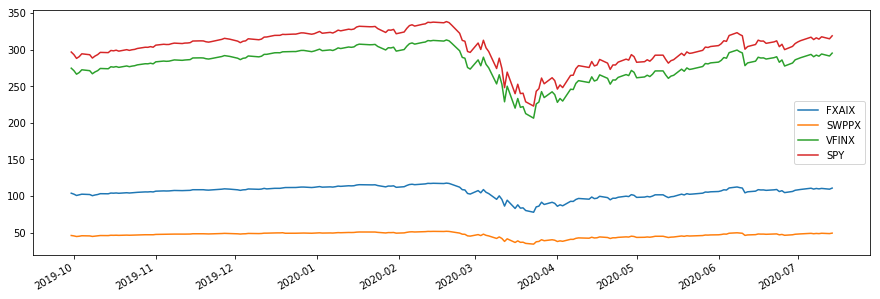

In [42]:
#Plotting price against time
plotLineGraph(SP500_fund_prices)

### Impact on certain industries in the market:

Tracking some of the largest airline companies (by revenue):
- Delta Air Lines, DAL
- American Airlines, AAL
- Deutsche Lufthansa, DLAKF
- United Airlines, UAL
- Air France KLM, AFRAF

Shown in the graph below, the airline industry was one of the largest areas hit by the pandemic

In [30]:
airlineCompanies = ['DAL','AAL','DLAKF','UAL','AFRAF']
airline_prices = bundleStockPrices(airlineCompanies, 200)

Any null data: False
              DAL     AAL  DLAKF    UAL  AFRAF
2019-09-30  57.60  26.970  15.92  88.41   10.4
2019-10-01  57.01  26.800  15.92  87.84   10.4
2019-10-02  54.35  25.370  15.92  83.69   10.4
2019-10-03  52.83  25.265  15.60  83.27   10.4
2019-10-04  53.81  25.830  15.10  84.29   10.4
...
              DAL    AAL  DLAKF    UAL  AFRAF
2020-07-09  25.65  11.18   9.90  30.17    4.4
2020-07-10  27.09  11.94   9.78  32.67    4.4
2020-07-13  26.82  11.63   9.96  31.76    4.5
2020-07-14  26.11  11.57   9.96  31.74    4.5
2020-07-15  28.60  13.44  10.45  36.37    4.5


<Figure size 1440x360 with 0 Axes>

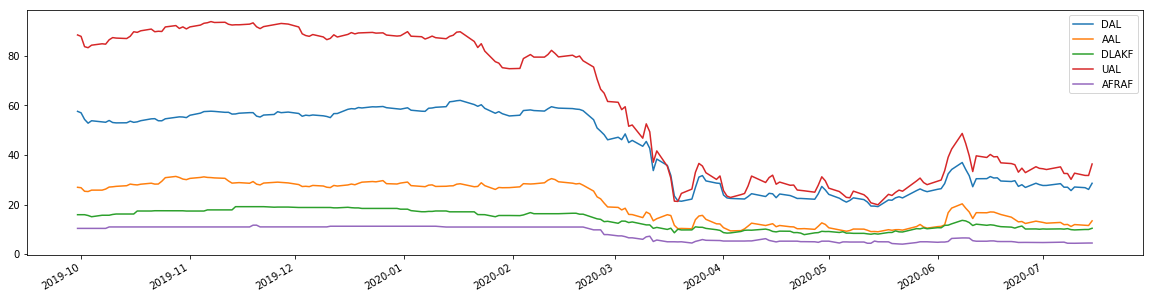

In [43]:
#Plotting price against time
plotLineGraph(airline_prices)
#To zoom in:
#plt.xlim(pd.to_datetime("2020-03-01"),pd.to_datetime("2020-04-01")) #Year-Month-Day

One part of the market that recovered reasonably well was the pharmaceutical industry:
- Johnson & Johnson, JNJ
- Roche, RHHBF
- Sinopharm Group, SHTDF
- Pfizer, PFE
- GlaxoSmithKline, GSK

In [34]:
biomedicalCompanies = ['JNJ','RHHBF','SHTDF','PFE','GSK']
biomedical_prices = bundleStockPrices(biomedicalCompanies, 200)

Any null data: False
               JNJ   RHHBF   SHTDF    PFE    GSK
2019-09-30  129.38  285.50  3.1200  35.93  42.68
2019-10-01  129.99  285.50  3.1200  35.43  42.31
2019-10-02  132.00  285.50  3.0800  34.70  41.19
2019-10-03  131.19  282.21  3.0800  35.45  41.45
2019-10-04  133.66  282.21  3.1701  35.93  41.99
...
               JNJ   RHHBF  SHTDF    PFE    GSK
2020-07-09  142.49  354.99   2.55  33.46  40.37
2020-07-10  142.37  347.20   2.57  33.83  39.91
2020-07-13  145.21  354.08   2.58  35.21  40.07
2020-07-14  147.92  352.12   2.50  35.23  40.70
2020-07-15  148.26  351.01   2.46  35.72  41.95


<Figure size 1440x360 with 0 Axes>

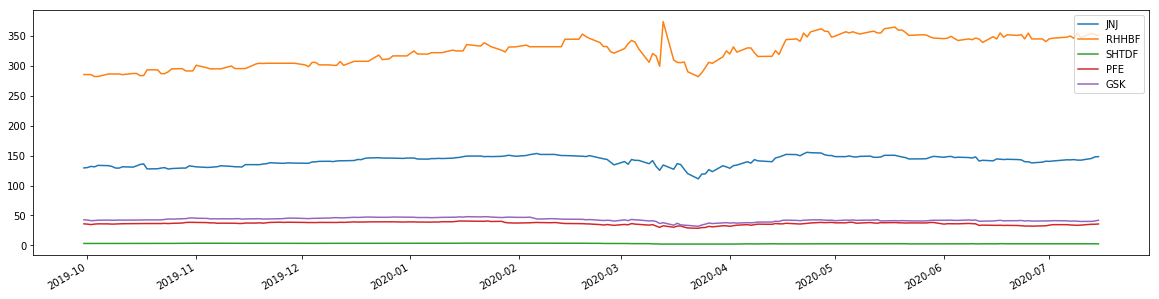

In [44]:
#Plotting price against time
plotLineGraph(biomedical_prices)
#To zoom in:
#plt.xlim(pd.to_datetime("2020-03-01"),pd.to_datetime("2020-04-01")) #Year-Month-Day

- Given the effect of COVID-19 on the market we seek to look at the daily percentage change of stock prices in the mentioned industries.
- Shown from the graph below we see that before COVID-19 the momentum of market stocks was relatively small and stable throughout the market. 
- Whilst the S&P500 index funds are down prior to the pandemic we see that along with the pharmaceutical industry the momentum of the stocks have almost returned to their original state before the pandemic
- Aviation has shown large momentum swings in both directions, indicating uncertainty of the stock prices and that more time is neeeded for the stocks to recovered back to previous trends.

In [46]:
#Function used to calculate the average percentage change of daily stock prices given a table with multiple stocks
def averagePctChange(table, industry):
    size = table.shape
    
    #Caluclate percentage change
    percentage_change = table.pct_change()
    
    #Remove the first row since that will not have a percentage change from the previous day
    percentage_change = percentage_change.drop(percentage_change.index[0])
    
    #Sum the values
    percentage_change[industry+" ROC"] = percentage_change.sum(axis = 1)
    
    #Divide by the length to get the average
    percentage_change[industry+" ROC"] =  percentage_change[industry+" ROC"].map(lambda x: x/size[1])
    
    #For loop to remove the the individual stock percentage changes
    for column in table:
        if column == industry+" ROC":
            break
        del percentage_change[column]
        
    return percentage_change

<Figure size 1440x360 with 0 Axes>

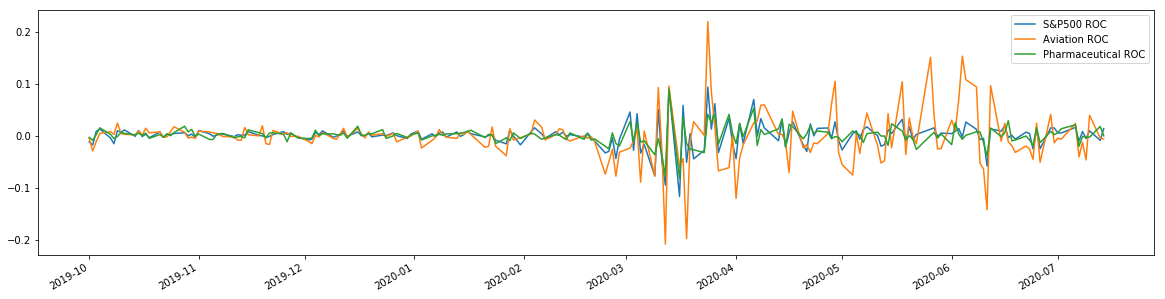

In [47]:
#Calculating the average percentage change from different industries
SP500_APC = averagePctChange(SP500_fund_prices, "S&P500")
airline_APC = averagePctChange(airline_prices, "Aviation")
bio_APC = averagePctChange(biomedical_prices, "Pharmaceutical")

ROC_data  = pd.concat([SP500_APC, airline_APC, bio_APC], axis = 1, join ='inner')

plotLineGraph(ROC_data)
#To zoom in:
#plt.xlim(pd.to_datetime("2020-03-01"),pd.to_datetime("2020-04-01")) #Year-Month-Day

In [48]:
def plotCorrelation(title, df, chartSize):
    try:
        corr = df.corr()
        fig, ax = plt.subplots(figsize=(chartSize,chartSize))
        ax.matshow(corr)
        #Display x axis with names
        plt.xticks(range(len(corr.columns)), corr.columns)
        #Display y axis with names
        plt.yticks(range(len(corr.columns)), corr.columns)
        #Display correlation graph
        plt.show()
    except:
        print("There was an error. Please check your dataframe.")